The MIT License (MIT)<br>
Copyright (c) 2018 Massachusetts Institute of Technology

Author: Justin Li and Cody Rude<br>
This software is part of the  NSF DIBBS Project "An Infrastructure for<br>
Computer Aided Discovery in Geoscience", PI: V. Pankratius<br>

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in<br>
all copies or substantial portions of the Software.<br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN<br>
THE SOFTWARE.

------------------

Initial imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
plt.rcParams['figure.dpi']=150

import pickle
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import h5py
import tqdm



from scipy.interpolate import interp2d
from skdiscovery.utilities.patterns.trend_tools import medianFilter
from sklearn.neighbors import KernelDensity
from scipy.interpolate import griddata, Rbf
from sklearn.mixture import GMM
from scipy.sparse import coo_matrix

from skdiscovery.utilities.patterns import atec_tools as utec

   
# grabbed Kp values from
#  http://wdc.kugi.kyoto-u.ac.jp/kp/
#  ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/ (reference)
# manually validated day-night terminator from

#  https://academo.org/demos/day-night-terminator/

Select time and location for Kaikoura Earthquake

In [2]:
doyN = 318;        dayNum = 318 - 1 + (11+(2+56/60)/60)/24
lat_0 = -42.757;   lon_0 = 173.077


# broader region of event
oset = 6
llat = lat_0-oset
ulat = lat_0+oset
llon = lon_0-oset
rlon = lon_0+oset

Read in data relevent to Kaikoura

In [3]:
data_location = 'data_example_gps/kaikoura_data.h5'
D_Kaikoura2016 = pd.read_hdf(data_location, 'sites'), pd.read_hdf(data_location,'tec')

Generate Hodochron

In [4]:
gH_K_0_signs = utec.genHodochron(D_Kaikoura2016,21,doyN,lat_0,lon_0)

Calculate differential TEC

In [5]:
dtec_K_0 = utec.genDTecs(21,D_Kaikoura2016,doyN)

Display GPS stations and select pierce points around Kaikoura

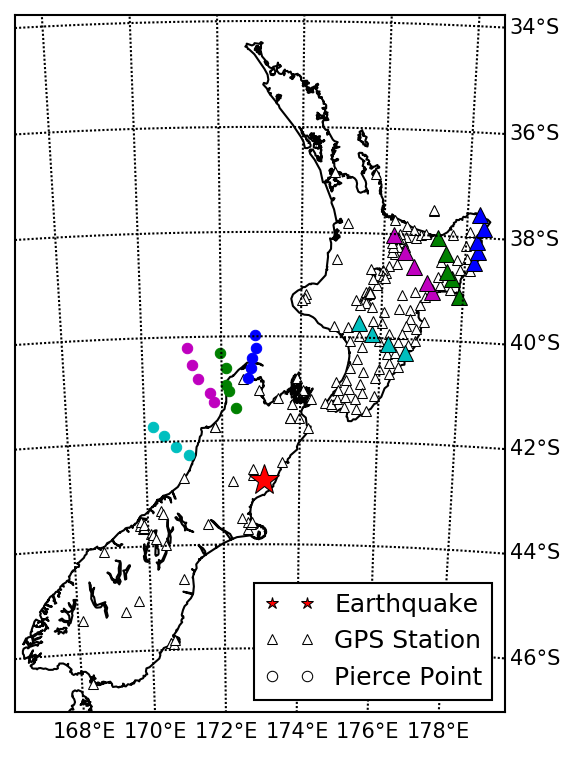

In [6]:
llat = lat_0-4.25
ulat = lat_0+9
llon = lon_0-7
rlon = lon_0+5.5
    
m = Basemap(projection='gnom',lat_0=lat_0,lon_0=lon_0, urcrnrlat=ulat, urcrnrlon=rlon,
            llcrnrlat=llat,llcrnrlon=llon, resolution='i')

plt.figure(figsize=(6,6));m.drawcoastlines();
m.plot(20,-20,'r*',latlon=True);
m.plot(20,-21,'k^',latlon=True,markersize=5,markerfacecolor='w');
m.plot(20,-22,'ko',latlon=True,markersize=5,markerfacecolor='w');

m.plot(D_Kaikoura2016[0].rec_lon.values,D_Kaikoura2016[0].rec_lat.values,'k^',latlon=True,markersize=5,markerfacecolor='w');
m.plot(lon_0,lat_0,'r*',markersize=15,latlon=True);

for asite in ['cnst','anau','puke','wmat','hikb']:
    tempDat = dtec_K_0.loc[(dtec_K_0.site.values==asite)*(dtec_K_0.index.values>(dayNum))*(dtec_K_0.index.values<(dayNum+1/24))]
    maxpt = tempDat.loc[np.argmax(tempDat.dtec)]
    m.plot(maxpt.pplon,maxpt.pplat,'b.',latlon=True,markersize=10);
    m.plot(D_Kaikoura2016[0].loc[asite].rec_lon,D_Kaikoura2016[0].loc[asite].rec_lat,'b^',latlon=True,markersize=8);
    
for asite in ['mahi', 'prtu','hana','matw','optk']:
    tempDat = dtec_K_0.loc[(dtec_K_0.site.values==asite)*(dtec_K_0.index.values>(dayNum))*(dtec_K_0.index.values<(dayNum+1/24))]
    maxpt = tempDat.loc[np.argmax(tempDat.dtec)]
    m.plot(maxpt.pplon,maxpt.pplat,'g.',latlon=True,markersize=10);
    m.plot(D_Kaikoura2016[0].loc[asite].rec_lon,D_Kaikoura2016[0].loc[asite].rec_lat,'g^',latlon=True,markersize=8);
    
for asite in ['wahu','rahi','ming','rgrr','rgka']:
    tempDat = dtec_K_0.loc[(dtec_K_0.site.values==asite)*(dtec_K_0.index.values>(dayNum))*(dtec_K_0.index.values<(dayNum+1/24))]
    maxpt = tempDat.loc[np.argmax(tempDat.dtec)]
    if asite=='ming':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[:25])]
    if asite=='rgrr':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[:30])]
    m.plot(maxpt.pplon,maxpt.pplat,'m.',latlon=True,markersize=10);
    m.plot(D_Kaikoura2016[0].loc[asite].rec_lon,D_Kaikoura2016[0].loc[asite].rec_lat,'m^',latlon=True,markersize=8);
    
for asite in ['pora', 'nrsw','ohin','whvr']:
    tempDat = dtec_K_0.loc[(dtec_K_0.site.values==asite)*(dtec_K_0.index.values>(dayNum))*(dtec_K_0.index.values<(dayNum+1/24))]
    maxpt = tempDat.loc[np.argmax(tempDat.dtec)]
    if asite=='pora':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[:22])]
    if asite=='nrsw':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[:25])]
    if asite=='ohin':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[20:25])]
    if asite=='whvr':
        maxpt = tempDat.loc[np.argmax(tempDat.dtec.iloc[20:30])]
    m.plot(maxpt.pplon,maxpt.pplat,'c.',latlon=True,markersize=10);
    m.plot(D_Kaikoura2016[0].loc[asite].rec_lon,D_Kaikoura2016[0].loc[asite].rec_lat,'c^',latlon=True,markersize=8);

parallels = np.arange(-48,-32,2);meridians = np.arange(166,180.,2);
m.drawparallels(parallels,labels=[False,True,True,False]);
m.drawmeridians(meridians,labels=[True,False,False,True]);
plt.legend(['Earthquake','GPS Station','Pierce Point'],loc=4);

Display dTEC for select station-satellite pairs

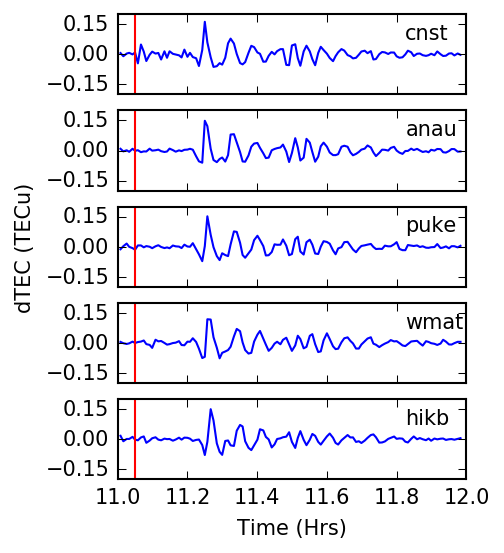

In [7]:
plt.figure(figsize=(3,4));
asite = 'cnst'
plt.subplot(511);plt.plot(gH_K_0_signs[1][asite],gH_K_0_signs[3][asite]);
plt.plot([11+(2+56/60)/60,11+(2+56/60)/60],[-.2,.2],'r'); plt.text(11.825,.075,asite);
plt.xlim(11,12);plt.ylim(-.2,.2); plt.gca().set_xticklabels([]);plt.yticks([-.15,0,.15]);
asite = 'anau'
plt.subplot(512);plt.plot(gH_K_0_signs[1][asite],gH_K_0_signs[3][asite]);
plt.plot([11+(2+56/60)/60,11+(2+56/60)/60],[-.2,.2],'r'); plt.text(11.825,.075,asite);
plt.xlim(11,12);plt.ylim(-.2,.2); plt.gca().set_xticklabels([]);plt.yticks([-.15,0,.15]);
asite = 'puke'
plt.subplot(513);plt.plot(gH_K_0_signs[1][asite],gH_K_0_signs[3][asite]);
plt.plot([11+(2+56/60)/60,11+(2+56/60)/60],[-.2,.2],'r'); plt.text(11.825,.075,asite); plt.ylabel('dTEC (TECu)');
plt.xlim(11,12);plt.ylim(-.2,.2); plt.gca().set_xticklabels([]);plt.yticks([-.15,0,.15]);
asite = 'wmat'
plt.subplot(514);plt.plot(gH_K_0_signs[1][asite],gH_K_0_signs[3][asite]);
plt.plot([11+(2+56/60)/60,11+(2+56/60)/60],[-.2,.2],'r'); plt.text(11.825,.075,asite);
plt.xlim(11,12);plt.ylim(-.2,.2); plt.gca().set_xticklabels([]);plt.yticks([-.15,0,.15]);
asite = 'hikb'
plt.subplot(515);plt.plot(gH_K_0_signs[1][asite],gH_K_0_signs[3][asite]);
plt.plot([11+(2+56/60)/60,11+(2+56/60)/60],[-.2,.2],'r'); plt.text(11.825,.075,asite);
plt.xlim(11,12);plt.ylim(-.2,.2);plt.yticks([-.15,0,.15]); plt.xlabel('Time (Hrs)');

Next, plot a Hodochron

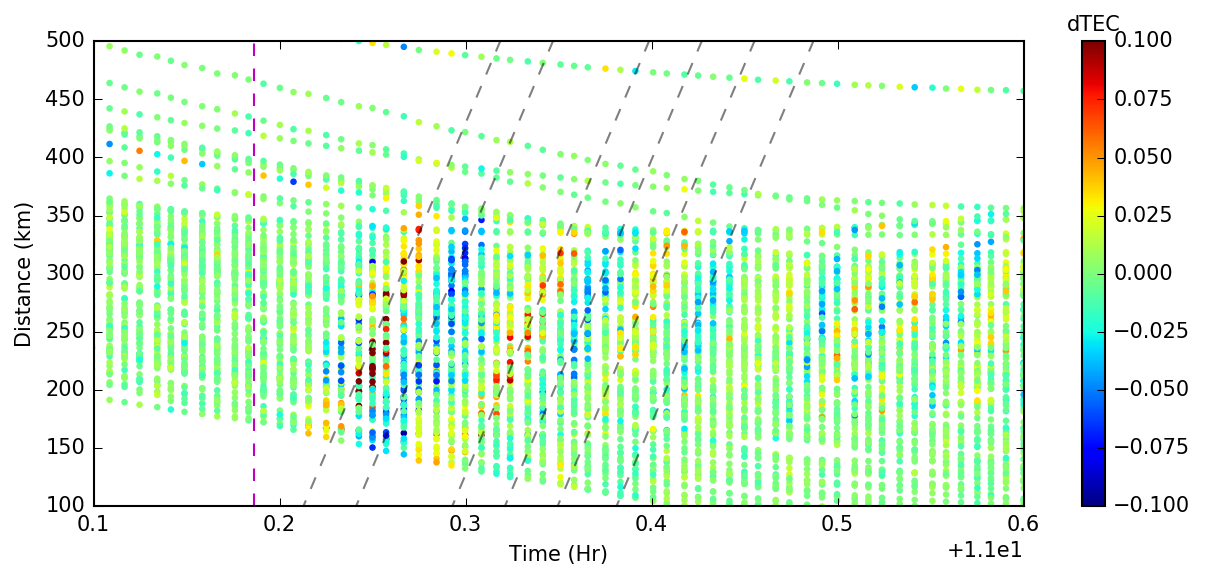

In [8]:
utec.plotHodochron(gH_K_0_signs,11+(2+56/60)/60,propTime=8.25,ms=10,figsize=(10,4),nDir=False);

plt.xlim(11.1,11.6); plt.ylim(100,500);
v_Cfac = 60*60/1000; eHRp = 11+(2+56/60)/60 + 8.25/60
t = np.linspace(eHRp,12.5,500)
# velocity profiles - Rayleigh, Shock Acoustic, Gravity
plt.plot(t, 1050*v_Cfac*(t-eHRp),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);
plt.plot(t, 1050*v_Cfac*(t-eHRp-1.7/60),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);
plt.plot(t, 1050*v_Cfac*(t-eHRp-4.8/60),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);
plt.plot(t, 1050*v_Cfac*(t-eHRp-6.5/60),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);
plt.plot(t, 1050*v_Cfac*(t-eHRp-8.2/60),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);
plt.plot(t, 1050*v_Cfac*(t-eHRp-10.1/60),'k--',alpha=.5); plt.plot(t, -1050*v_Cfac*(t-eHRp),'k--',alpha=.5);